Back to the [Random Forest notebook](./random-forest.ipynb)

Back to the [ML notebook](./ml.ipynb)

To the [README](./README.md)

--------------------------------------------------------------------------------

# Artificial Neural Network

In [36]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import ConfusionMatrixDisplay, root_mean_squared_error

# set the theme for seaborn graphics
sns.set_theme(context='paper', style='whitegrid')

In [37]:
# load the training and testing data
df_train_ = pd.read_csv('data/df_train.csv', index_col=0)
df_test_ = pd.read_csv('data/df_test.csv', index_col=0)

In [38]:
# extract four locations; we want to have one model per location
df_train = [
    df_train_[df_train_.Location=='Location 1'].drop('Location', axis=1),
    df_train_[df_train_.Location=='Location 2'].drop('Location', axis=1),
    df_train_[df_train_.Location=='Location 3'].drop('Location', axis=1),
    df_train_[df_train_.Location=='Location 4'].drop('Location', axis=1),
]
df_test = [
    df_test_[df_test_.Location=='Location 1'].drop('Location', axis=1),
    df_test_[df_test_.Location=='Location 2'].drop('Location', axis=1),
    df_test_[df_test_.Location=='Location 3'].drop('Location', axis=1),
    df_test_[df_test_.Location=='Location 4'].drop('Location', axis=1),
]

In [39]:
# define target and features
X_train = [
    df_train[0].drop('Power', axis=1),
    df_train[1].drop('Power', axis=1),
    df_train[2].drop('Power', axis=1),
    df_train[3].drop('Power', axis=1),
]
y_train = [
    df_train[0].Power,
    df_train[1].Power,
    df_train[2].Power,
    df_train[3].Power,
]

X_test = [
    df_test[0].drop('Power', axis=1),
    df_test[1].drop('Power', axis=1),
    df_test[2].drop('Power', axis=1),
    df_test[3].drop('Power', axis=1),
]
y_true = [
    df_test[0].Power,
    df_test[1].Power,
    df_test[2].Power,
    df_test[3].Power,
]

In order to try out a few different architectures we are going to use a
`GridSearchCV` from `scikit-learn` and feed it a few suggestions for the
hidden layer compositions.

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
# instantiate the mase estimator
base_estimator = MLPRegressor(
    activation='tanh',          # default: 'relu'
    validation_fraction=.2,     # default: 0.1
    batch_size=1000,            # default: min(200, n_samples)
    alpha=.00001,               # default: 0.0001
    learning_rate_init=.0005,   # default: 0.001
    random_state=404
)

# create the parameter grid--the suggested architectures
hidden_layer_suggestions = {
    'hidden_layer_sizes': [
        (512,),
        (256,),
        (128,),
        (64,),
        (32,),
        (16,),
        (256, 256),
        (128, 128),
        (64, 64),
        (32, 32),
        (16, 16),
        (128, 256, 128),
        (64, 128, 64),
        (64, 256, 64),
        (128, 128, 128),
        (64, 64, 64),
        (32, 64, 32),
        (16, 32, 16),
        (16, 32, 64, 32, 16)
    ]
}
# create the grid search instances; one for each location
ann = [
    GridSearchCV(
        estimator=base_estimator,
        param_grid=hidden_layer_suggestions,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    ) for _ in range(4)
]

In [42]:
# train the model
_ = [model.fit(X, y) for (model, X, y) in zip(ann, X_train, y_train)]

In [43]:
# make predictions
y_pred = [
    model.predict(X)
    for (model, X) in zip(ann, X_test)
]

In [44]:
# evaluate the results
for idx, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
    print(f'Location {idx+1}:\tRMSE = {root_mean_squared_error(y_t, y_p)}')

Location 1:	RMSE = 0.16749669470568268
Location 2:	RMSE = 0.15708161930388614
Location 3:	RMSE = 0.20542811260672567
Location 4:	RMSE = 0.11783060455630727


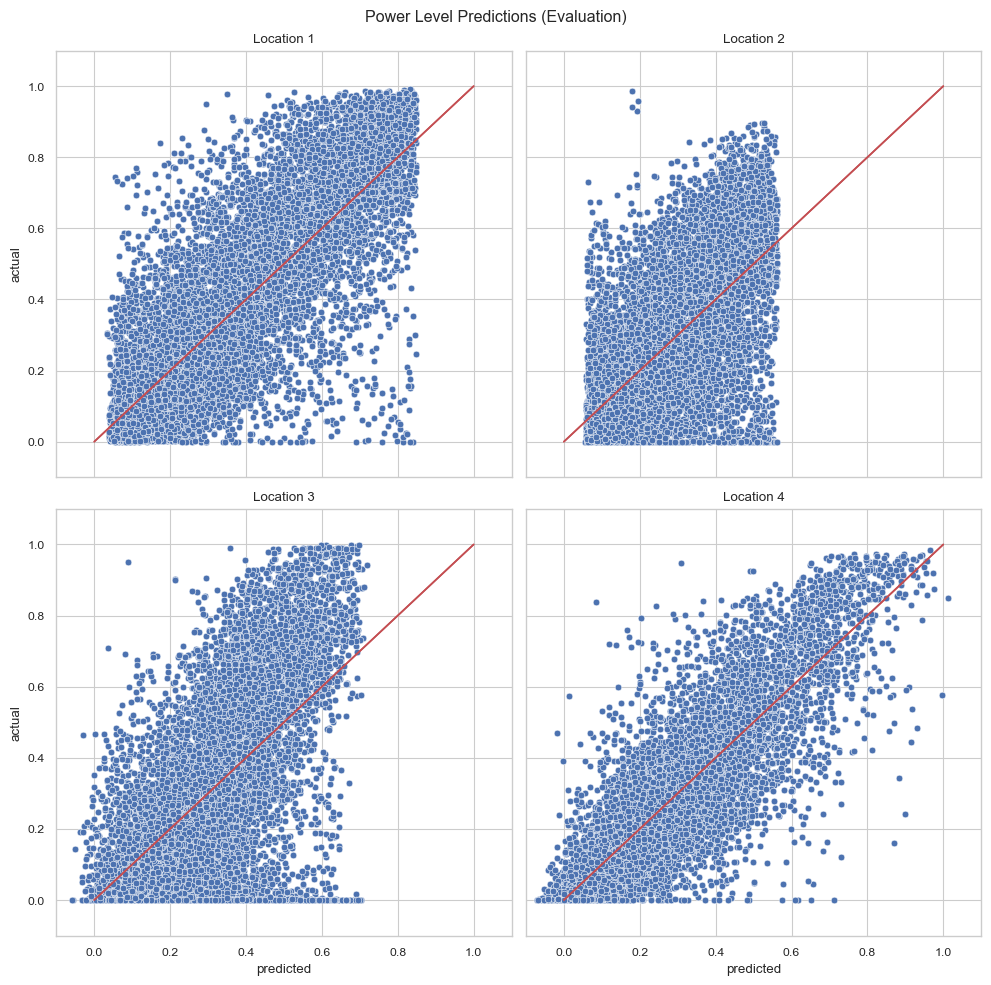

In [45]:
# visualize predictions
fig, _ = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(10,10)
for idx, (y_t, y_p) in enumerate(zip(y_true, y_pred)):
    plt.subplot(2, 2, idx+1)
    data = pd.DataFrame({
        'actual': y_t,
        'predicted': y_p
    })
    sns.scatterplot(data, x='predicted', y='actual')
    #sns.lineplot([[0, 1]], legend=None)
    plt.plot([[0,0], [1,1]], color='r')
    plt.title(f'Location {idx+1}')
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.suptitle('Power Level Predictions (Evaluation)')
plt.tight_layout()
plt.show()

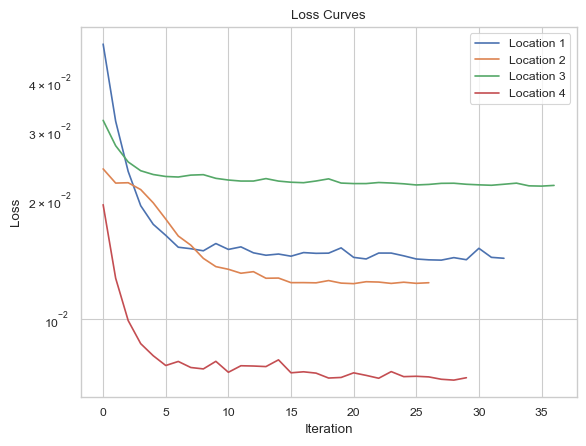

In [46]:
for idx, model in enumerate(ann):
    sns.lineplot(model.best_estimator_.loss_curve_, label=f'Location {idx+1}')
plt.title('Loss Curves')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()